In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import collections
import os



In [183]:
plates = {f"plate{fn[6:9]}": pd.read_csv(os.path.join("Data", fn), sep = '\t') for fn in os.listdir("Data")}
full_plates = sorted(list(plates.keys()))

num_stain_sets = 3
staining_set_size = 8
staining_sets = [full_plates[staining_set_size * stain_idx:staining_set_size * (stain_idx + 1)] for stain_idx in range(num_stain_sets)]

In [184]:
key_properties_to_cols = {
    "count": "Spot_PA_SpotCellCount",
    # "cell_area": "Cells_CP_AreaShape_Area", # this is missing in some plates? TODO: find out why
    # "cytoplasm_area": "Cytoplasm_CP_AreaShape_Area", # same here
    "nuclear_area": "Nuclei_CP_AreaShape_Area",
}

property_to_min_max = {}
for key_property in key_properties_to_cols:
    col_name = key_properties_to_cols[key_property]
    min_prop = np.min([np.min([plates[plate_name][col_name].min() for plate_name in staining_set]) for staining_set in staining_sets])
    max_prop = np.max([np.max([plates[plate_name][col_name].max() for plate_name in staining_set]) for staining_set in staining_sets])
    property_to_min_max[col_name] = (min_prop, max_prop)

In [185]:
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

# arghh, got these +1s and -1s floating around cause the data's 1 indexed...
def gen_well_viz_property(plate, well_idx, property):
    well = plate[plate["WellIndex"] == well_idx + 1]
    well_rows, well_cols = 35, 20
    well_heatmap = np.zeros((well_rows, well_cols))
    well_heatmap[well["ArrayRow"] - 1, well["ArrayColumn"] - 1] = well[property]
    return well_heatmap

def viz_well(well_heatmap):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
    sns.heatmap(well_heatmap, ax=ax)
    plt.show()

def viz_plate_property(plate, property):    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
    plt.subplots_adjust(wspace=0, hspace=0)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    well_heatmaps = [gen_well_viz_property(plate, well_idx, property) for well_idx in range(8)]
    min_prop, max_prop = property_to_min_max[property]
    well_rows, well_cols = 35, 20

    # for well_idx, well_heatmap in enumerate(well_heatmaps):
    for well_idx, ax in enumerate(axs.flat):
        well_row, well_col = well_idx // 4, well_idx % 4
        ax = axs[well_row, well_col]

        ax.axhline(y=0, color='k',linewidth=3)
        ax.axhline(y=well_rows, color='k',linewidth=3)
        ax.axvline(x=0, color='k',linewidth=3)
        ax.axvline(x=well_cols, color='k',linewidth=3)

        sns.heatmap(
            well_heatmaps[well_idx], ax=ax, vmin=min_prop, vmax=max_prop, linewidths=1, 
            linecolor='black', xticklabels=False, yticklabels=False, 
            cbar=(well_idx == 0), cbar_ax=None if well_idx else cbar_ax
        )
    plt.show()

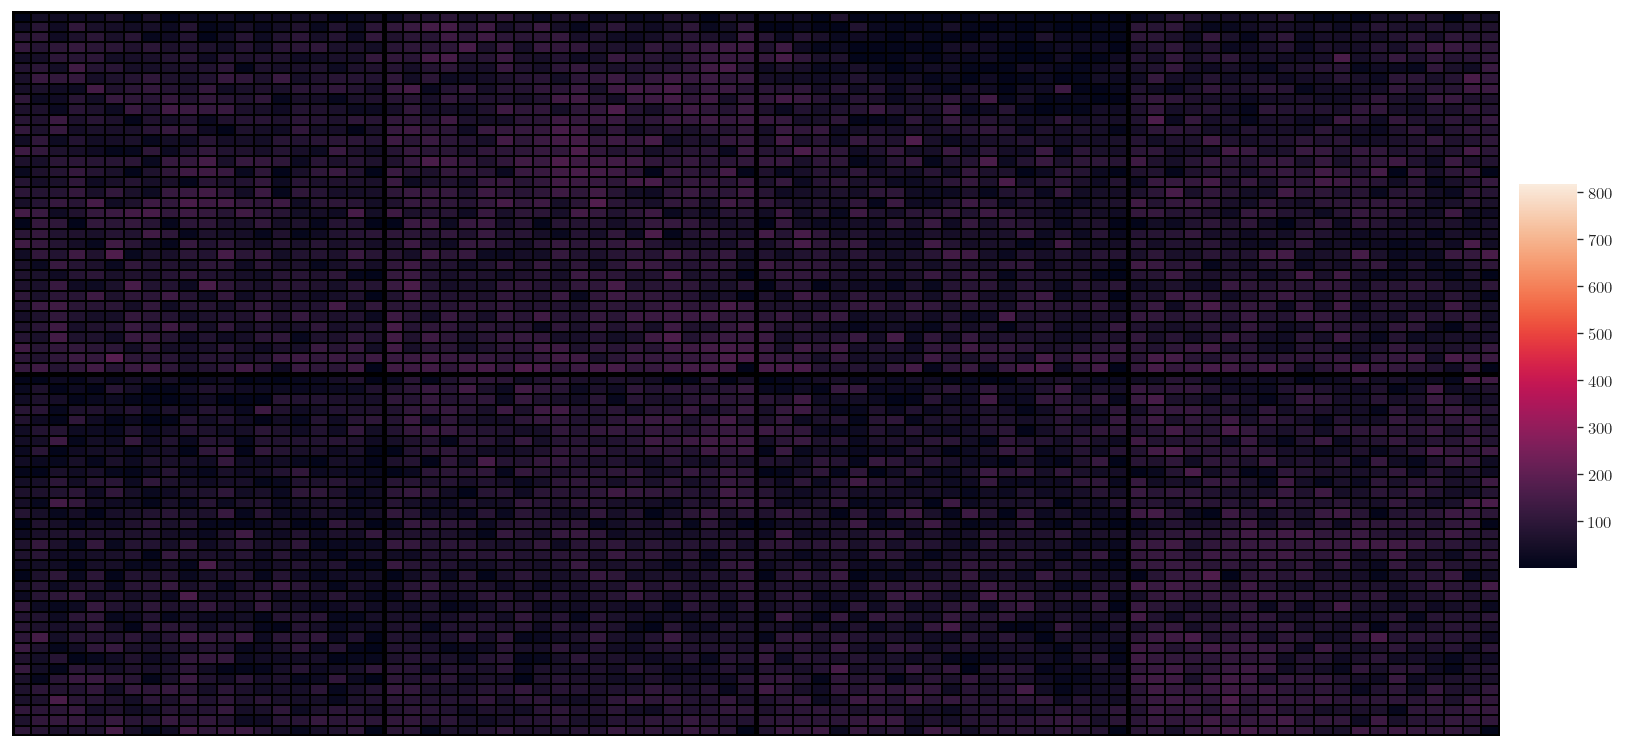

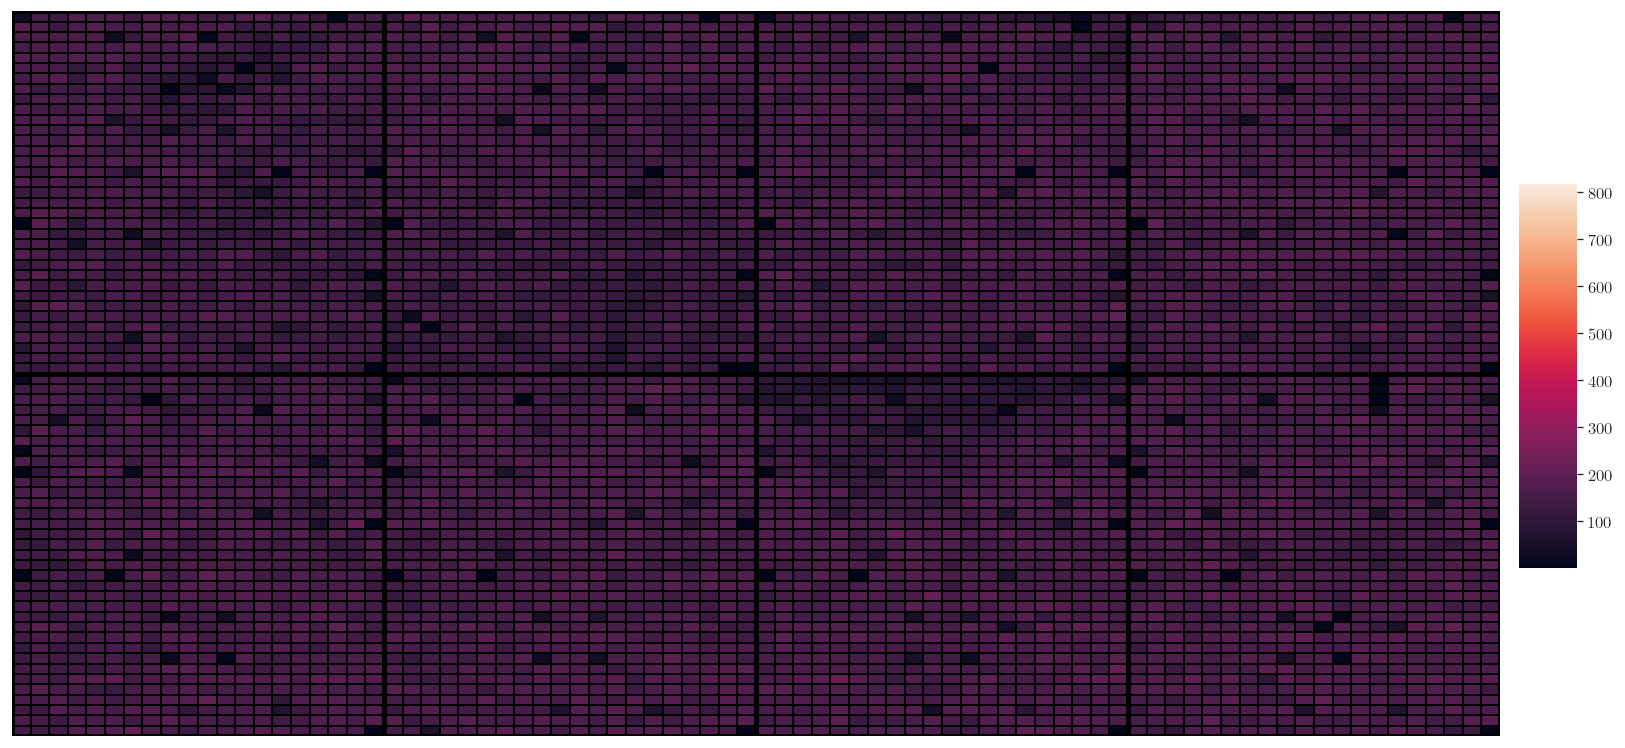

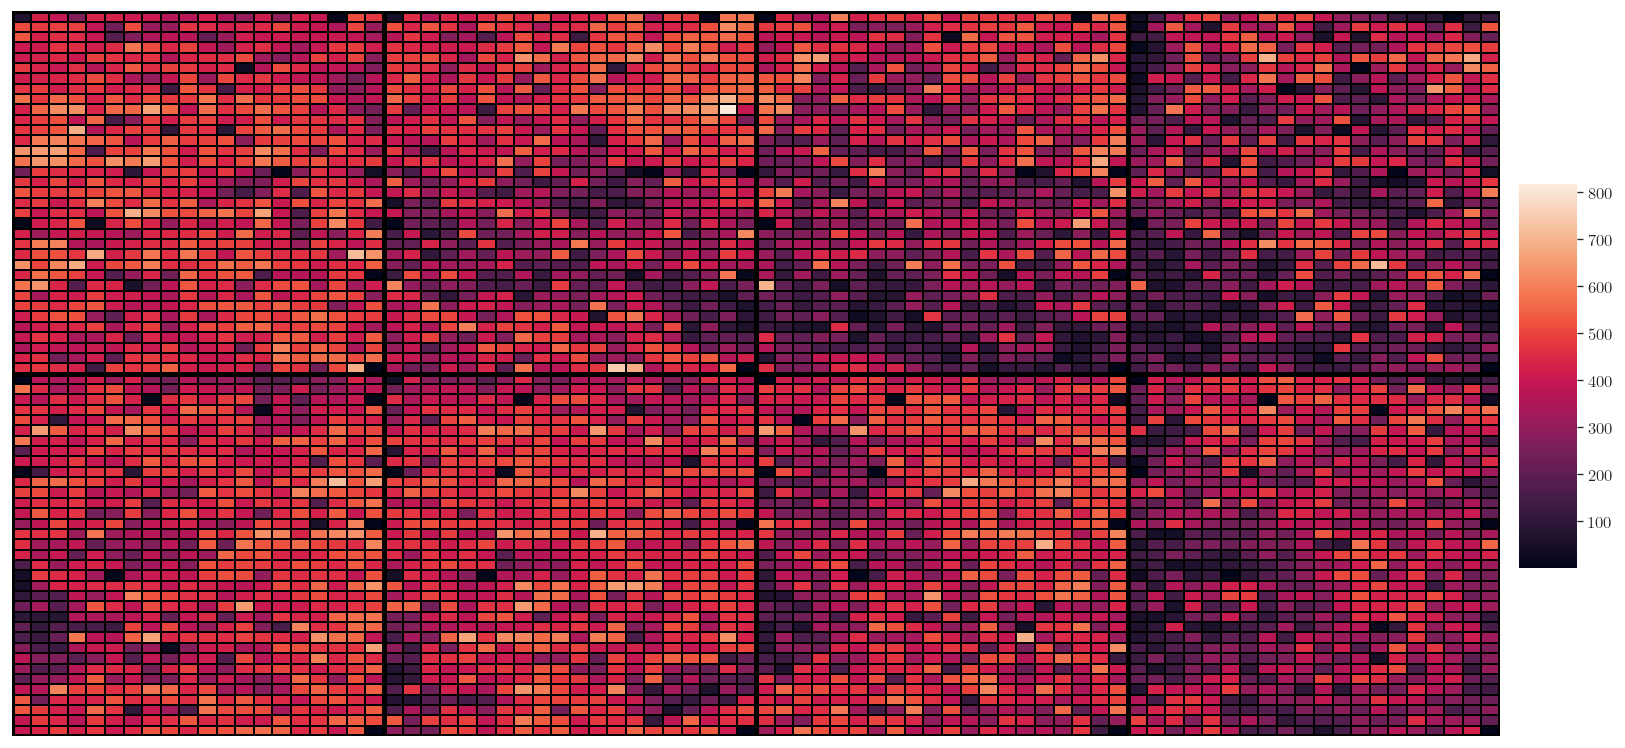

In [188]:
# NOTE: these supposedly "equivalent" staining sets are definitely not -- need to normalize the counts/properties for analysis
for staining_set in staining_sets:
    cur_plate = plates[staining_set[1]]
    viz_plate_property(cur_plate, key_properties_to_cols["count"])

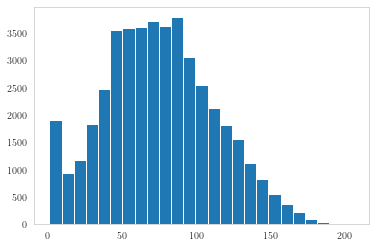

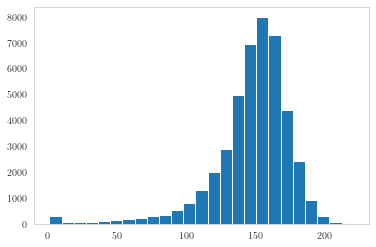

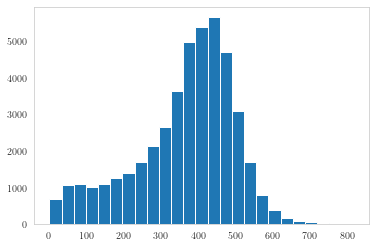

In [220]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name][key_properties_to_cols["count"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    plt.hist(full_counts, bins=25)
    plt.show()